# Chapter 8

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch08-baggboost-lab-zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/ISLP_labs/blob/main/static_files/presentations/Ch08-baggboost-lab-zh.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [1]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c8302b9937597a79fbcc0bb78a8ac5133b46321dbf7f2ae52bbb286ac89d3acb
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [2]:
%pip install catboost -qq
%pip install dtreeviz -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.5 MB/s eta 0:00:00


In [1]:
# 本 Notebook 使用的匯入（imports）
import time  # 計時/效能量測
import logging  # 記錄器設定
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
import seaborn as sns  # 統計視覺化
import matplotlib.pyplot as plt  # 繪圖指令與樣式
from matplotlib.pyplot import subplots  # 建立子圖與繪圖版面
from sklearn import datasets  # 範例資料集
from sklearn.model_selection import (  # 資料切分與評估/搜尋
    train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
)
import sklearn.model_selection as skm  # 模型選擇工具別名 (skm)
from sklearn.preprocessing import StandardScaler, LabelEncoder  # 特徵標準化/標籤編碼
from sklearn.pipeline import make_pipeline  # 前處理 + 模型串接
from sklearn.linear_model import LogisticRegression  # 邏輯斯回歸
from sklearn.naive_bayes import GaussianNB  # 高斯樸素貝葉斯
from sklearn.neighbors import KNeighborsClassifier  # KNN 分類器
from sklearn.tree import (
    DecisionTreeClassifier as DTC, DecisionTreeClassifier, DecisionTreeRegressor, plot_tree,
    export_graphviz, DecisionTreeRegressor as DTR, export_text
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor,
    VotingClassifier, StackingClassifier, RandomForestRegressor as RF,
    GradientBoostingRegressor as GBR
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error,
    log_loss
)
from xgboost import XGBClassifier, XGBRegressor  # XGBoost 分類/回歸
import lightgbm as lgb  # LightGBM 套件別名
from lightgbm import LGBMRegressor  # LightGBM 回歸
from catboost import CatBoostClassifier, CatBoostRegressor, Pool  # CatBoost 分類/回歸與資料容器
import dtreeviz  # 決策樹視覺化
import graphviz  # 圖形渲染
from ISLP import load_data, confusion_table  # ISLP 資料載入與混淆表
from ISLP.models import ModelSpec as MS  # 模型規格工具
from ISLP.bart import BART  # Bayesian Additive Regression Trees

# 實驗：樹狀方法

我們必須重新啟動執行環境以使用新安裝的版本！

In [2]:
%matplotlib inline

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Require extra installation
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL) # For dtreeviz

## 擬合分類樹

我們首先使用分類樹來分析 [`Carseats`](https://islp.readthedocs.io/en/latest/datasets/Carseats.html) 資料集。在這些資料中，`Sales` 是一個連續變數，所以我們首先將其重新編碼為二元變數。我們使用 `where()` 函數來建立一個稱為 `High` 的變數，如果 `Sales` 變數超過 8，則取值 `Yes`，否則取值 `No`。

In [4]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

In [5]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


我們現在使用 `DecisionTreeClassifier()` 來擬合分類樹，以使用除了 `Sales` 之外的所有變數來預測 `High`。為了這樣做，我們必須像擬合迴歸模型時一樣形成模型矩陣。

In [6]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

我們已將 `D` 從資料框轉換為陣列 `X`，這在下面的一些分析中是需要的。我們也需要 `feature_names` 來稍後標註我們的圖。

需要指定分類器的幾個選項，如 `max_depth`（樹要成長多深）、`min_samples_split`（節點要符合分割資格的最少觀測數）和 `criterion`（是否使用 Gini 或交叉熵作為分割準則）。我們也設定 `random_state` 以便重現；分割準則中的平手會隨機打破。

In [7]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

在第 3.3 節討論類別特徵時，我們注意到對於線性迴歸模型，這類特徵可以透過在模型矩陣中加入虛擬變數（one-hot encoding）來表示，使用 `statsmodels` 的公式記法。

如第 8.1 節所述，在建構決策樹時有更自然的方式處理類別特徵，不需要這些虛擬變數；每次切分相當於將水準分為兩組。然而，`scikit-learn` 的決策樹實作並未利用這種方法；它只是將 one-hot 編碼的水準視為獨立變數。

In [8]:
accuracy_score(High, clf.predict(X))

0.79

僅使用預設參數時，訓練錯誤率是 21%。

對於分類樹，我們可以使用 `log_loss()` 存取偏差值：
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
其中 $n_{mk}$ 是第 $m$ 個終端節點中屬於第 $k$ 類的觀測數。

In [9]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

np.float64(0.4710647062649358)

這與 (8.7) 式定義的 *熵（entropy）* 密切相關。小的偏差表示樹對訓練資料提供良好的擬合。

樹最吸引人的特性之一是它們可以圖形化顯示。我們使用 `plot()` 函數來顯示樹結構。

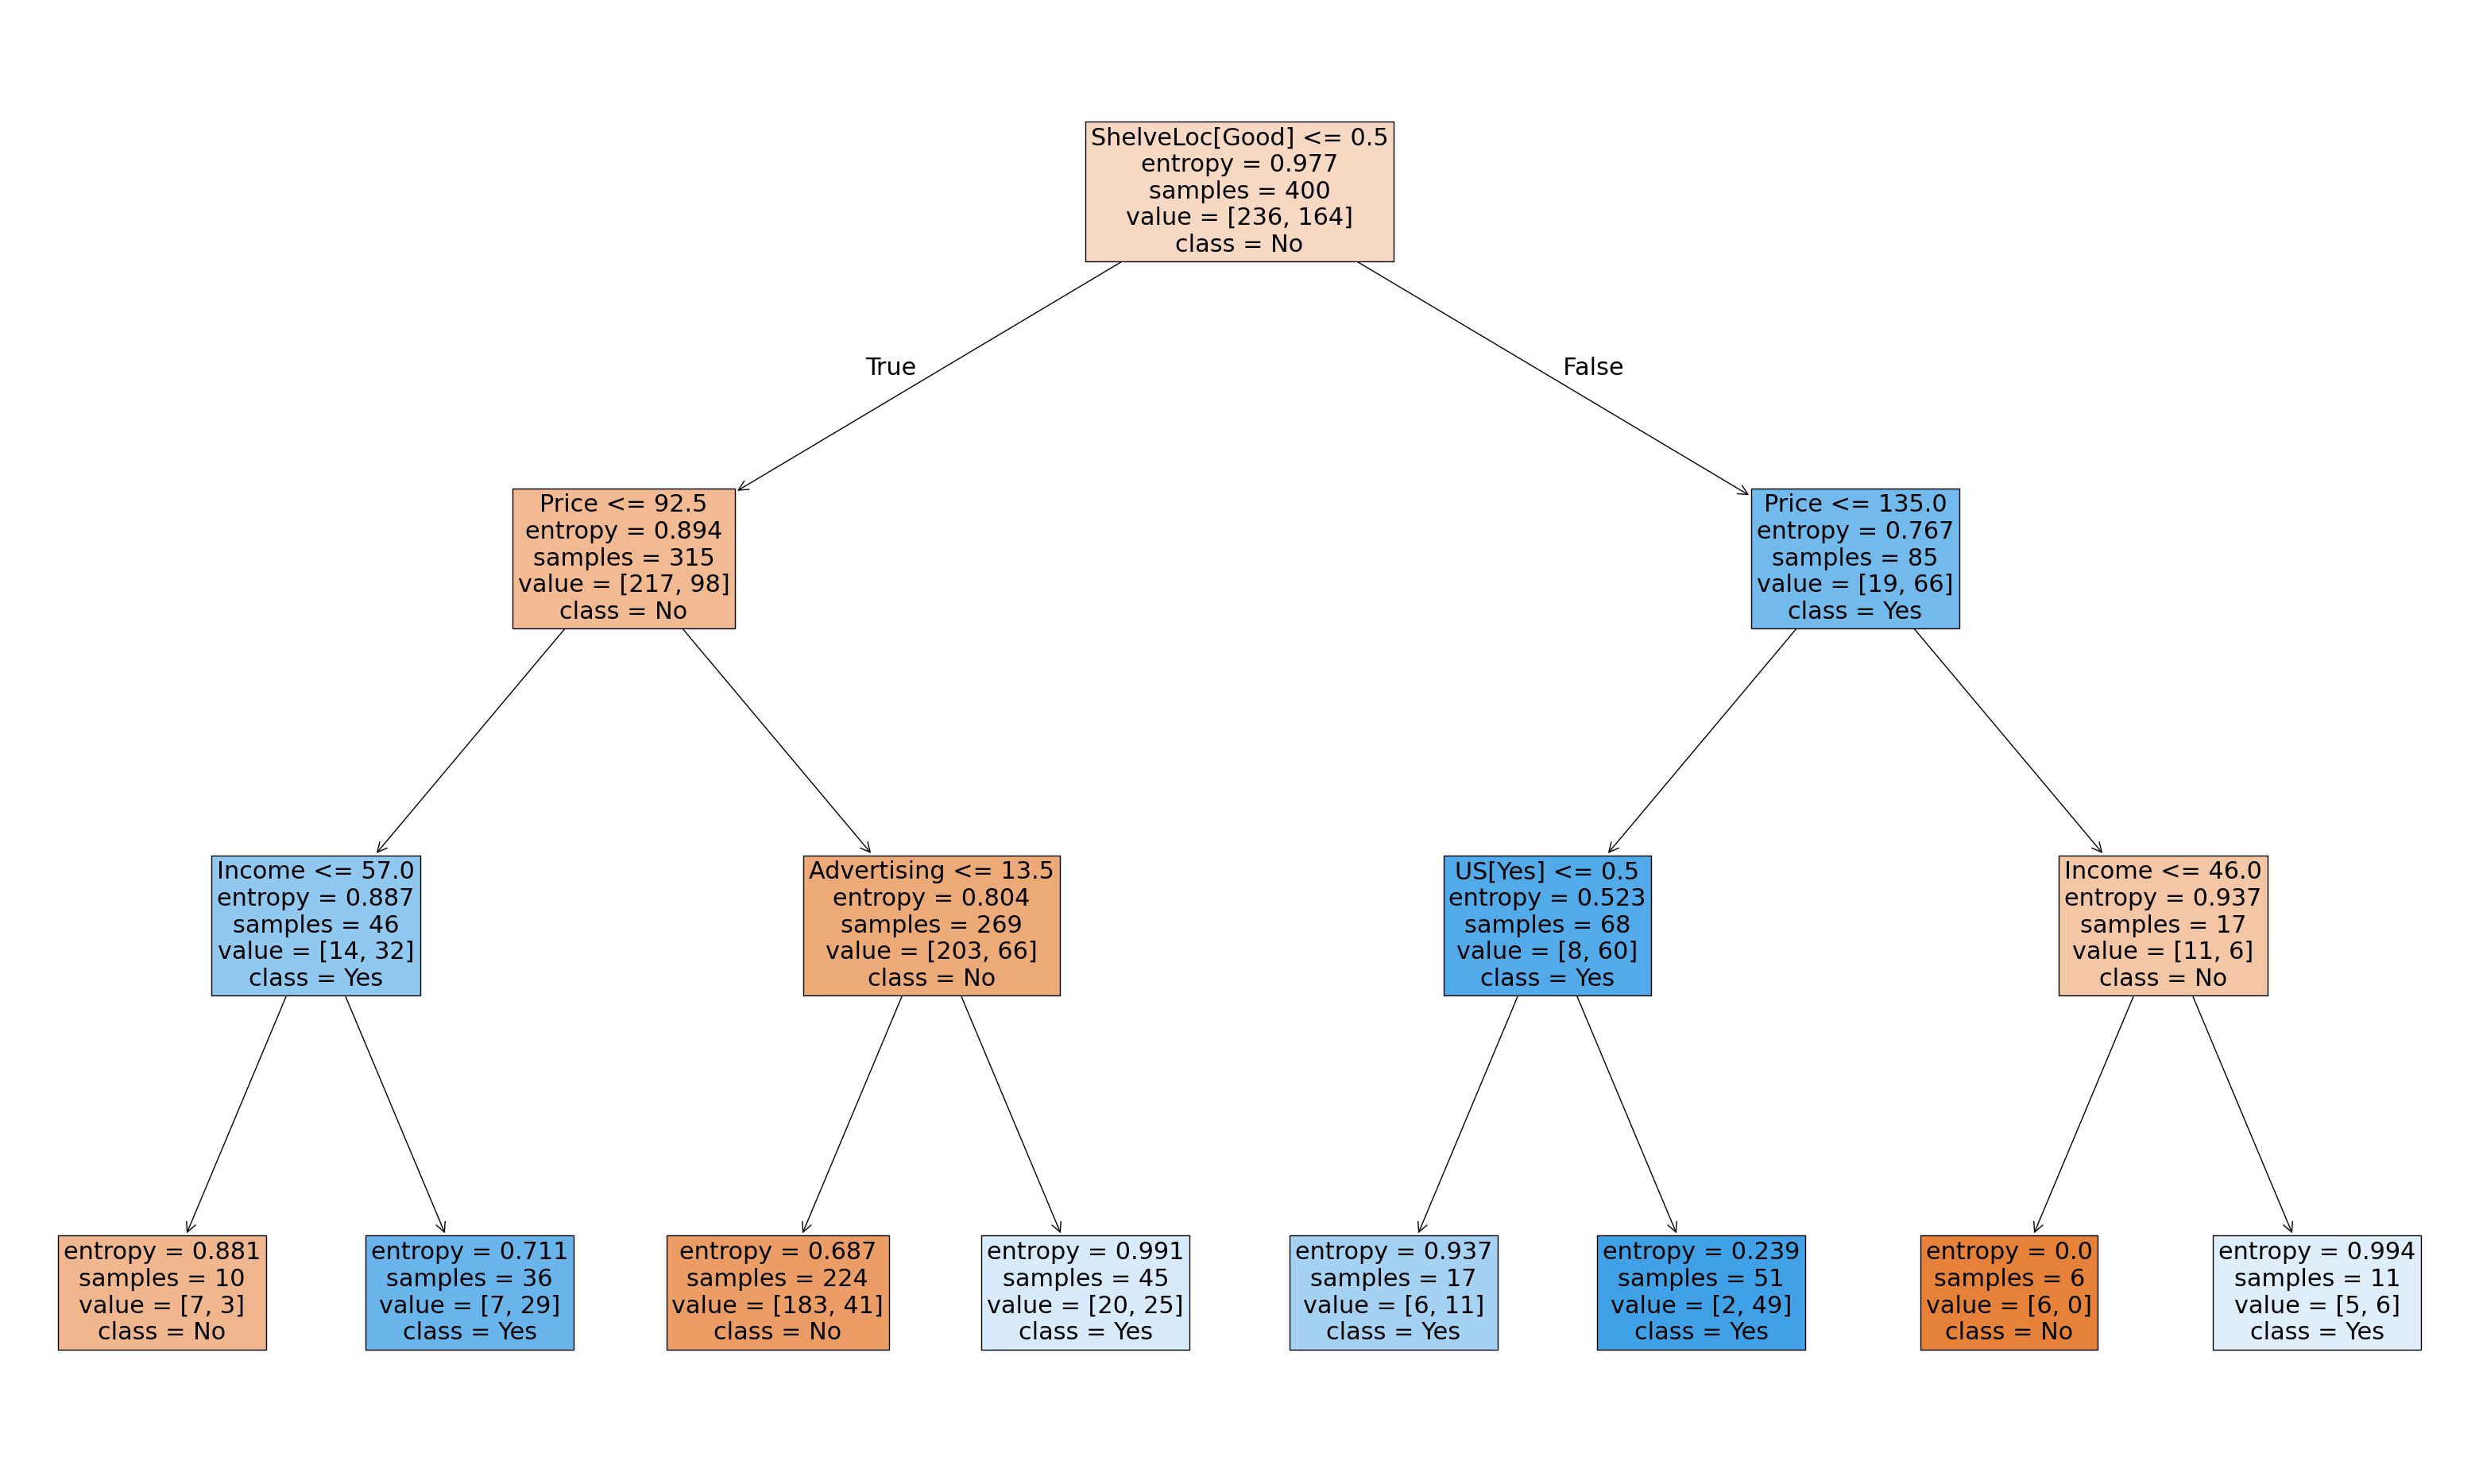

In [10]:
ax = subplots(figsize=(40,24))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax,
          class_names=['No','Yes'],
          filled=True);

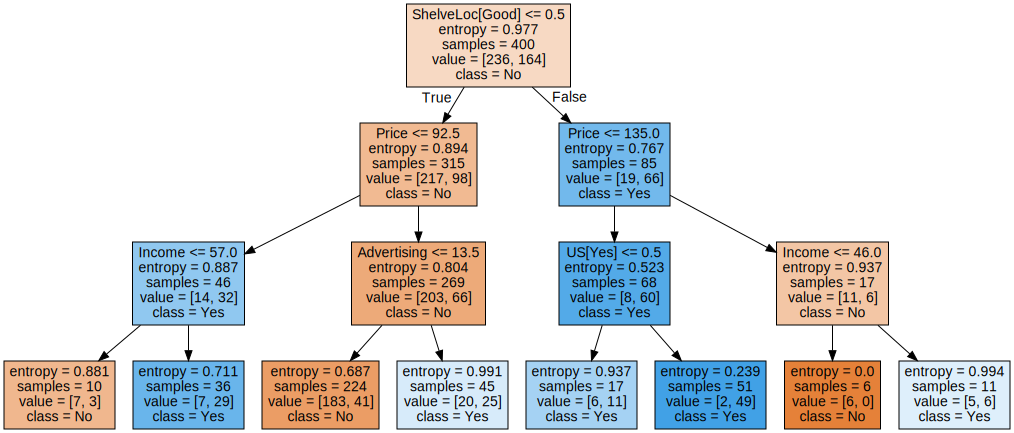

In [11]:
dot_data = export_graphviz(clf, feature_names=feature_names,
                    class_names=['No','Yes'],
                    filled=True, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("tree1")
graph

In [12]:
label_encoder = LabelEncoder()
High_encoded = label_encoder.fit_transform(High)

In [13]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)
clf.fit(X, High_encoded)

viz_model = dtreeviz.model(clf,
                           X_train=X,
                           y_train=High_encoded,
                           feature_names = feature_names,
                           target_name='y', class_names=['No','Yes'])

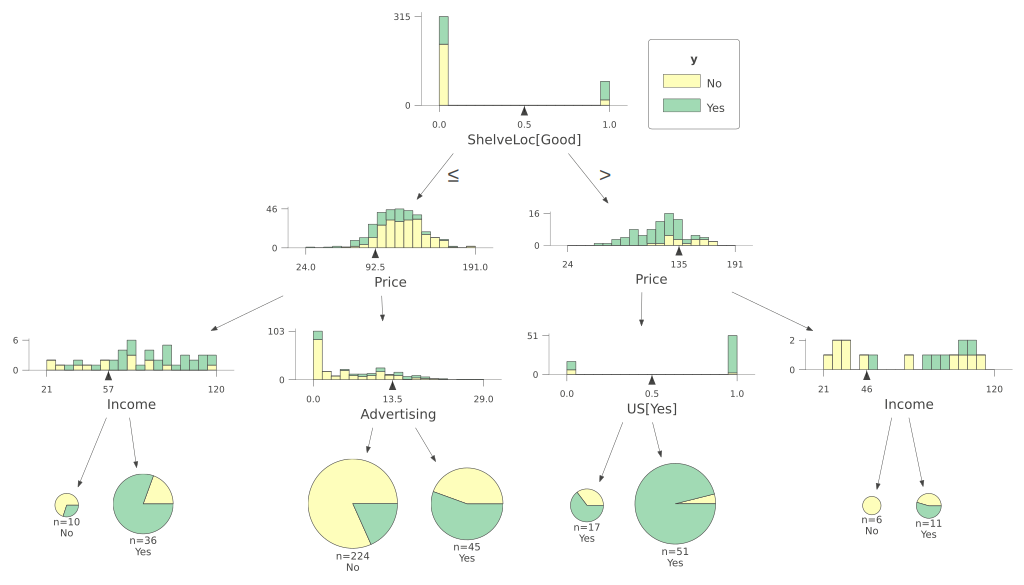

In [14]:
viz_model.view(scale=1.5)

`Sales` 最重要的指標似乎是 `ShelveLoc`。

我們可以使用 `export_text()` 看到樹的文字表示，它顯示每個分支的切分準則（例如 `Price <= 92.5`）。對於葉節點，它顯示整體預測（`Yes` 或 `No`）。我們還可以透過指定 `show_weights=True` 來查看該葉節點中取值為 `Yes` 和 `No` 的觀測數。

In [15]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: 0
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: 1
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: 0
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: 1
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: 1
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: 1
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: 0
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: 1



為了適當評估分類樹在這些資料上的性能，我們必須估計測試誤差而非僅僅計算訓練誤差。我們將觀測切分為訓練集和測試集，使用訓練集建構樹，並在測試資料上評估其性能。這種模式類似第 6 章，只是這裡用決策樹替代了線性模型 --- 驗證的程式碼幾乎相同。這種方法對測試資料集中 68.5% 的位置產生正確預測。

In [16]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']

array([0.685])

接著我們考慮是否修剪樹可能導致分類性能的提升。我們首先將資料切分為訓練集和測試集。我們將使用交叉驗證在訓練集上修剪樹，然後在測試集上評估修剪樹的性能。

In [17]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)

我們首先在訓練集上重新擬合完整的樹；這裡我們不設定 `max_depth` 參數，因為我們將透過交叉驗證來學習該參數。

In [18]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

接下來我們使用 `clf` 的 `cost_complexity_pruning_path()` 方法來提取成本複雜度值。

In [19]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

這產生了一組不純度和 $\alpha$ 值，我們可以透過交叉驗證從中提取最佳值。

In [20]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

np.float64(0.685)

讓我們看看修剪後的樹。

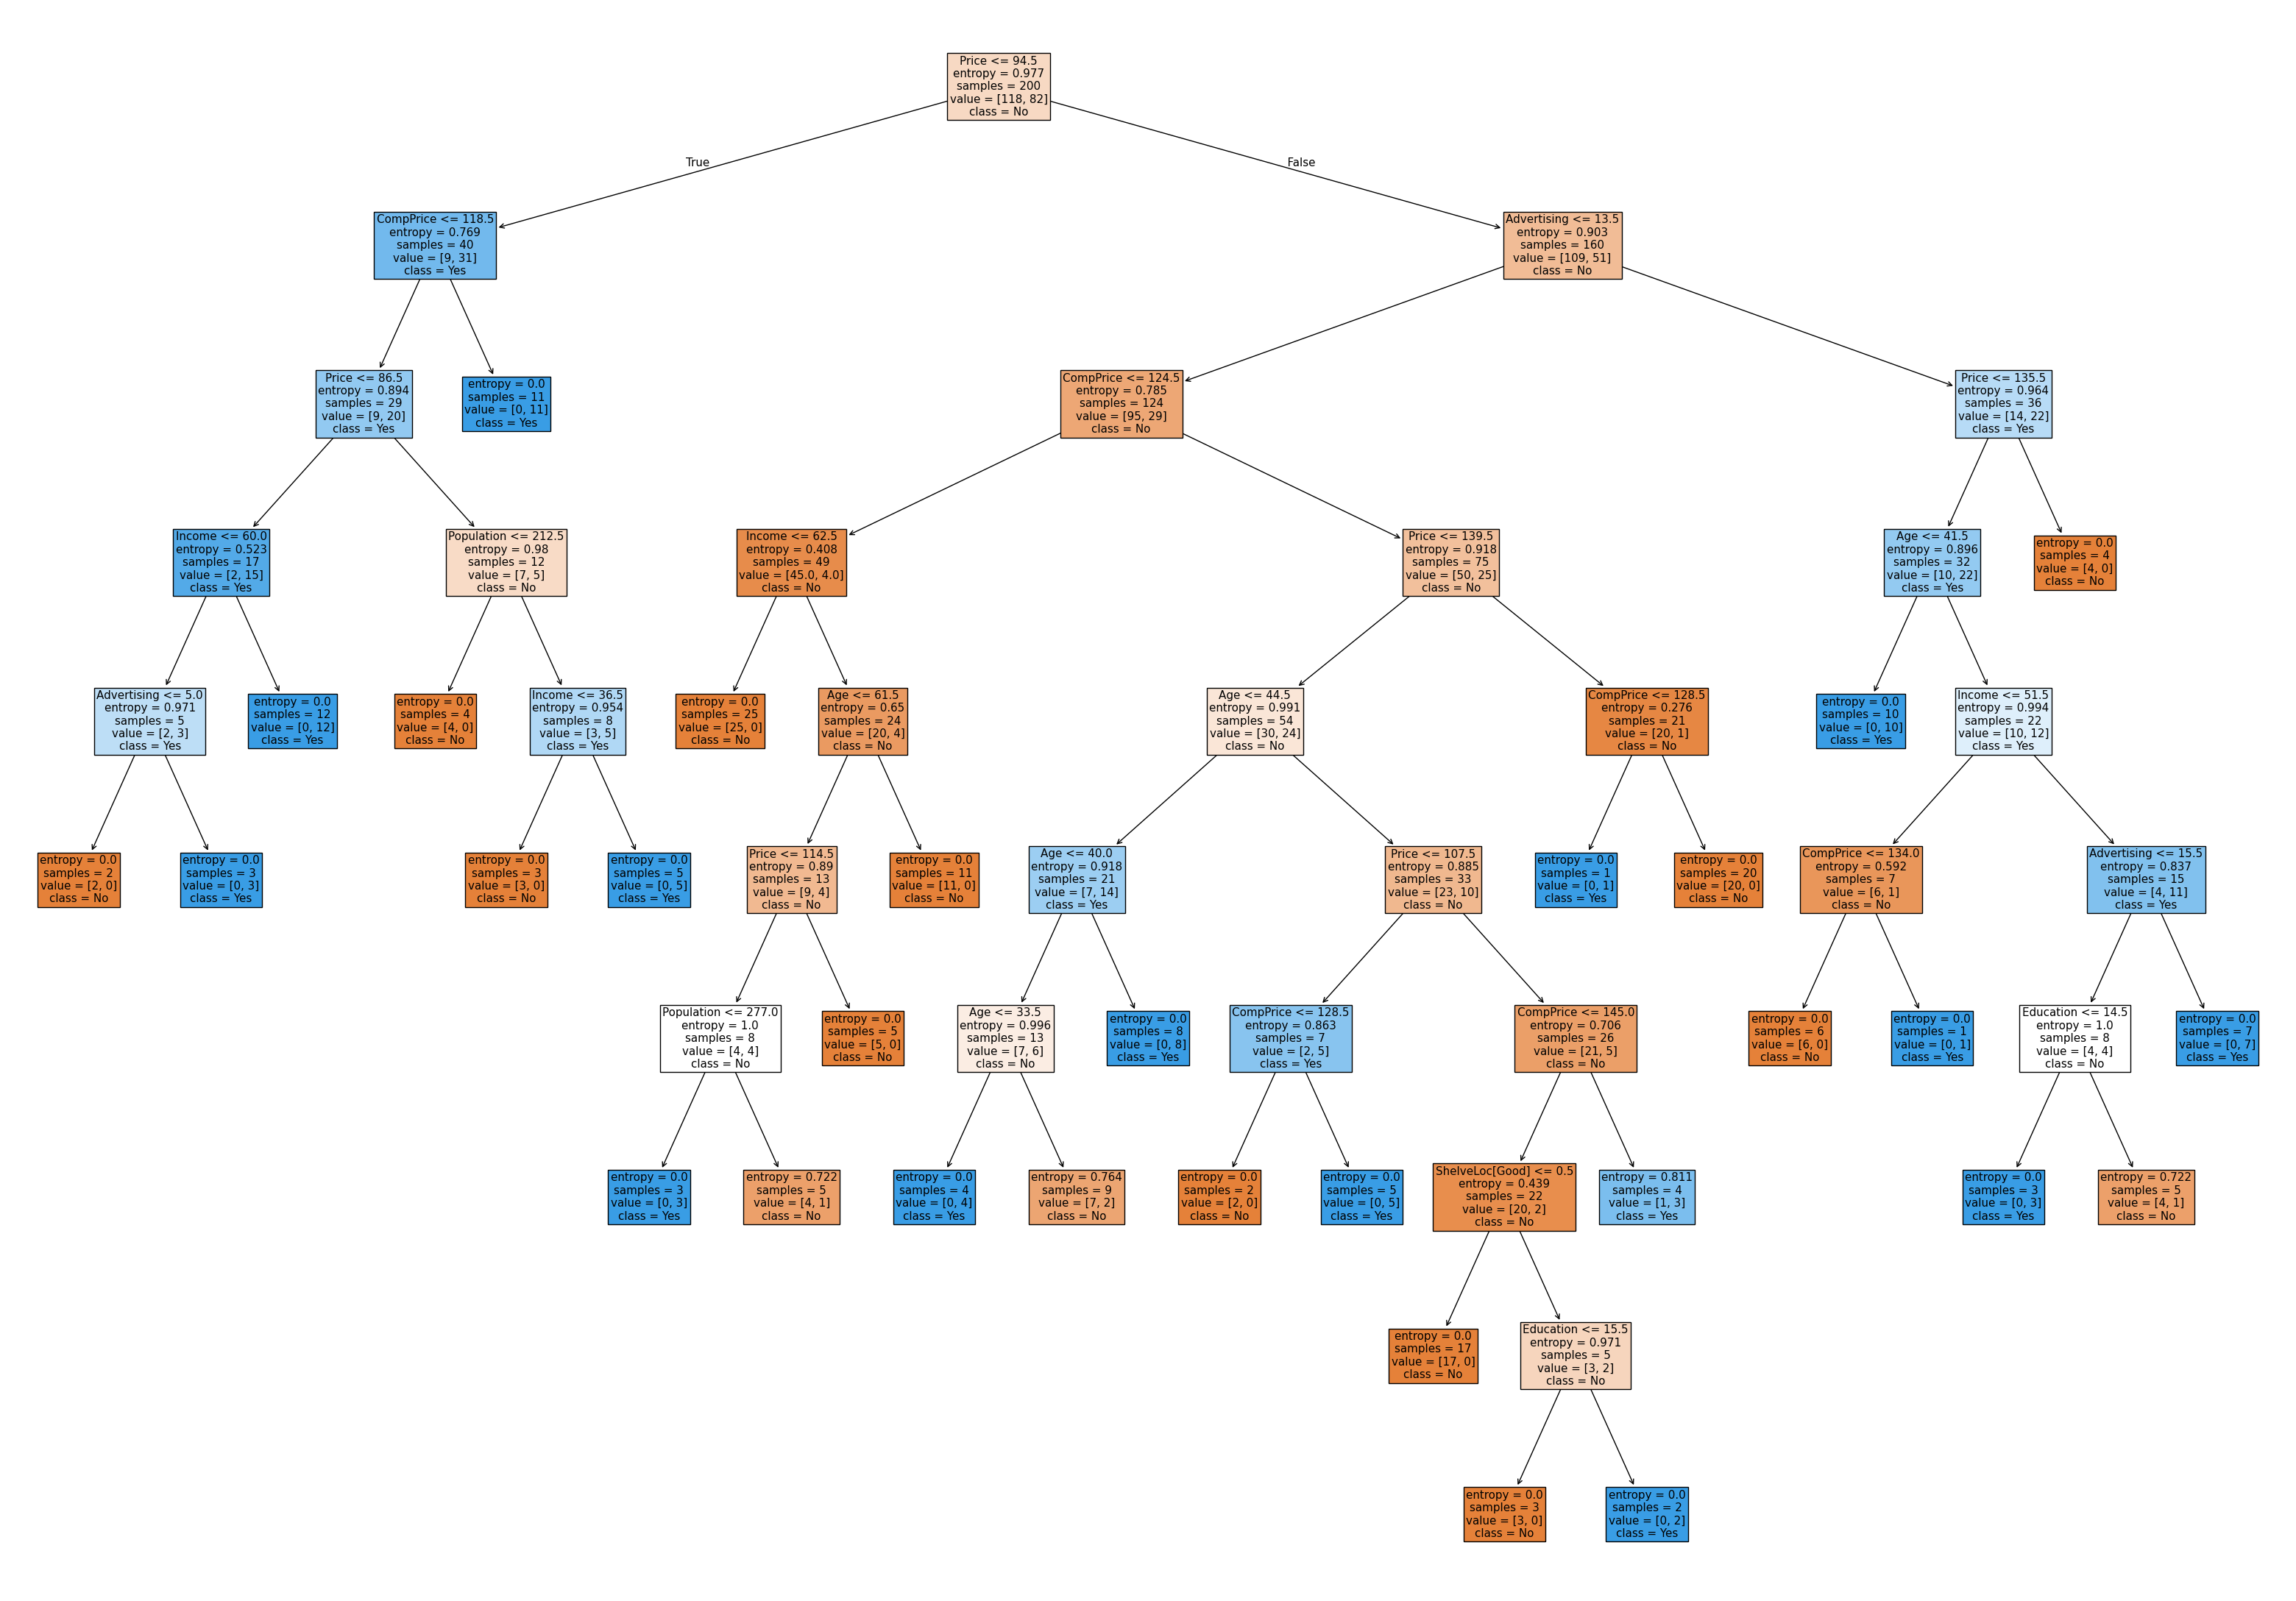

In [21]:
ax = subplots(figsize=(40, 28))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax,
          class_names=['No','Yes'],
          filled=True);

這是一棵相當茂密的樹。我們可以計算葉節點數，或改為查詢 `best_`。

In [22]:
best_.tree_.n_leaves

np.int64(30)

有 30 個終端節點的樹產生最低的交叉驗證錯誤率，準確率為 68.5%。這棵修剪後的樹在測試資料集上表現如何？我們再次使用 `predict()` 函數。

In [23]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


現在 72.0% 的測試觀測被正確分類，這比完整樹（35 個葉節點）的錯誤略差。所以交叉驗證在這裡對我們的幫助不大；它只修剪了 5 個葉節點，代價是稍差的錯誤率。如果我們改變上面的隨機數種子，這些結果會改變；儘管交叉驗證提供無偏的模型選擇方法，它確實有變異數。

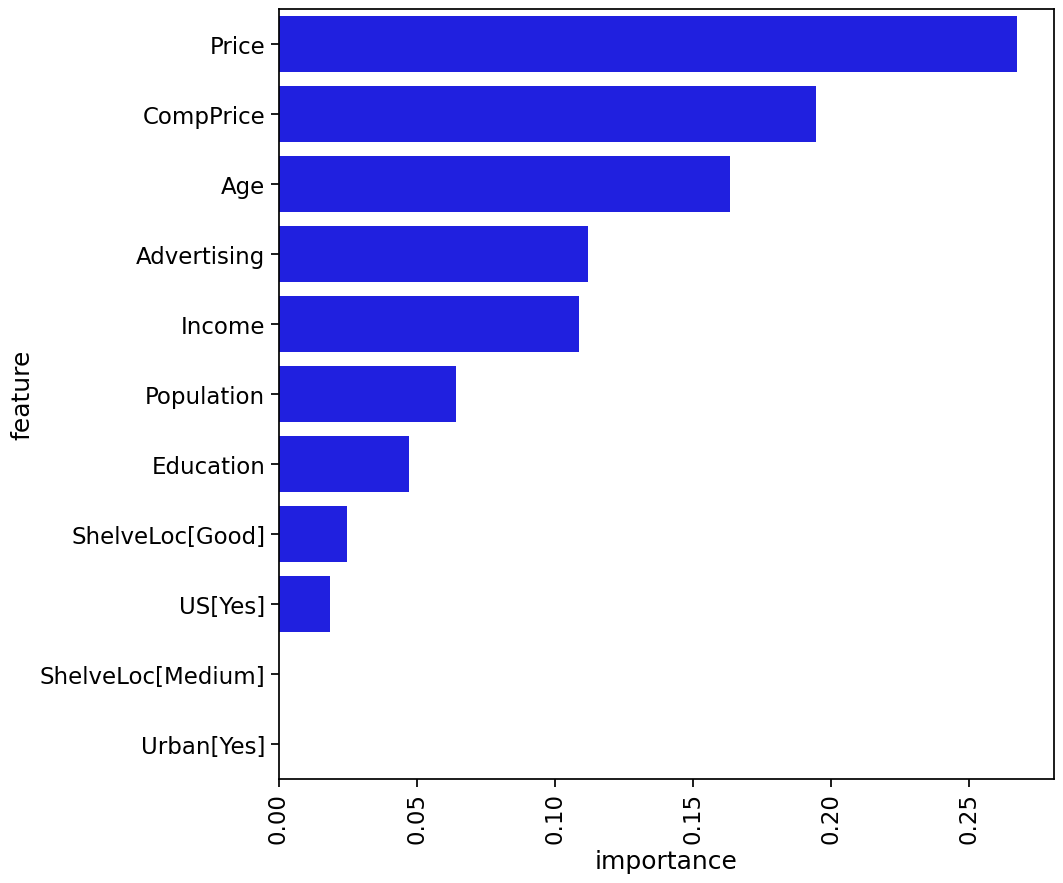

In [24]:
# 按特徵在此模型中的重要性繪圖
plot_df = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

## 擬合回歸樹

在這裡我們對 [`Boston`](https://islp.readthedocs.io/en/latest/datasets/Boston.html) 資料集擬合一個回歸樹。步驟與分類樹相似。

In [25]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

首先，我們將資料切分為訓練集和測試集，並在訓練資料上擬合樹。這裡我們使用 30% 的資料作為測試集。

In [26]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)

在形成我們的訓練和測試資料集後，我們擬合回歸樹。

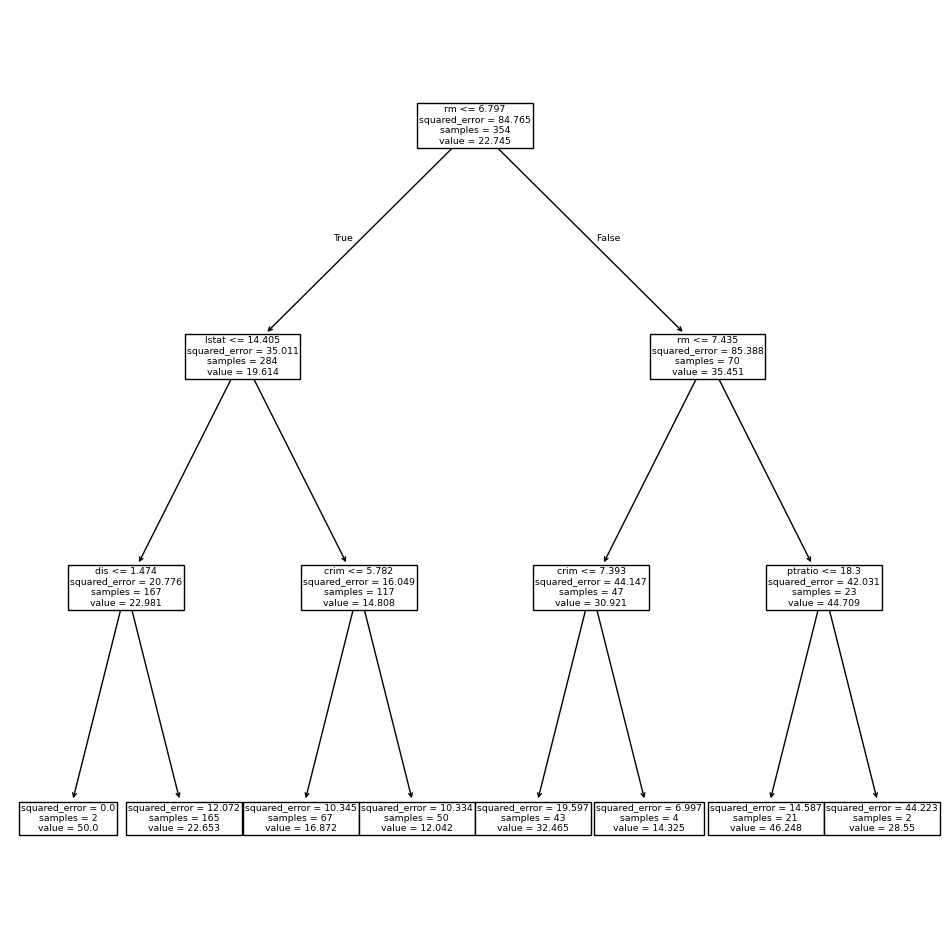

In [27]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

變數 `lstat` 測量低社經地位個體的百分比。樹表明 `lstat` 的較低值對應較昂貴的房屋。對於居民社經地位較低（`lstat > 14.4`）且犯罪率中等（`crim > 5.8`）郊區的小型住宅（`rm < 6.8`），樹預測房屋中位價格為 12,042 美元。

現在我們使用交叉驗證函數來查看修剪樹是否會改善性能。

In [28]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

根據交叉驗證結果，我們使用修剪後的樹在測試集上進行預測。

In [29]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

np.float64(28.069857549754044)

換句話說，與回歸樹相關聯的測試集 MSE 是 28.07。MSE 的平方根因此約為 5.30，表明這個模型導致的測試預測在郊區真實房屋中位價值約 5,300 美元範圍內。

讓我們繪製最佳樹，看看它的可解釋性。

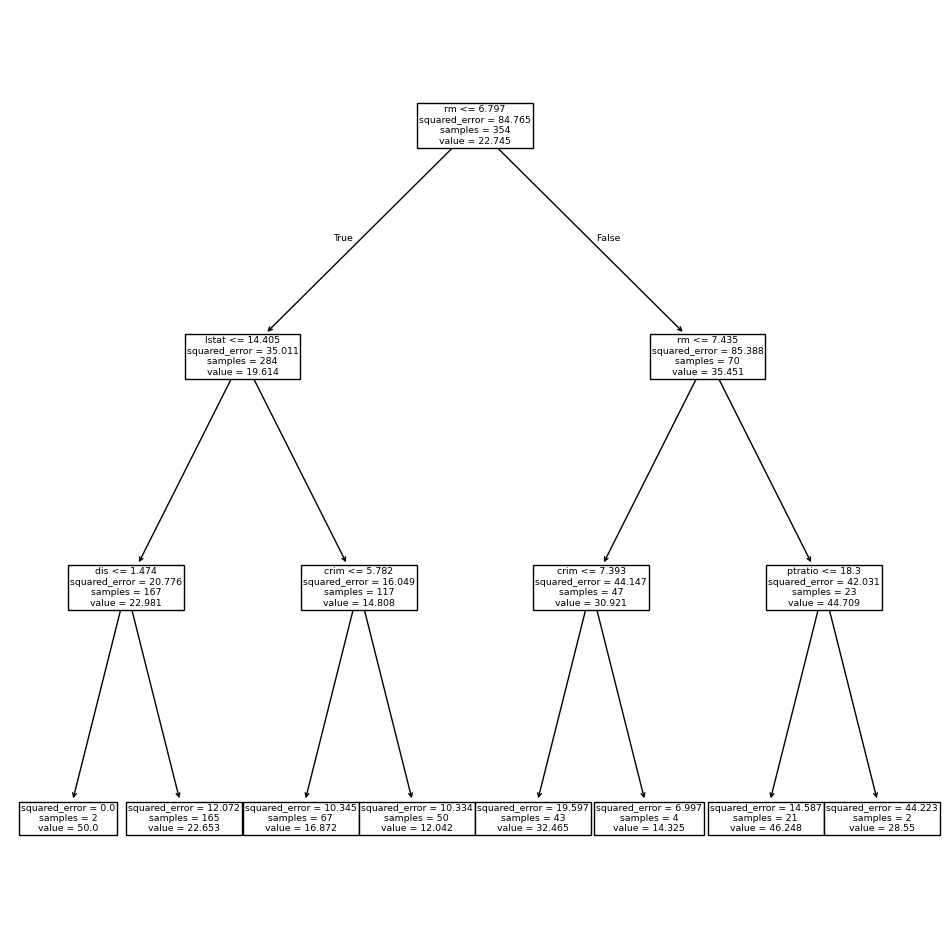

In [30]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

## Bagging 與隨機森林

在這裡我們對 `Boston` 資料應用 Bagging 和隨機森林，使用 `scikit-learn.ensemble` 套件的 `RandomForestRegressor()`。回想 Bagging 只是隨機森林在 $m=p$ 時的特殊情況。因此，`RandomForestRegressor()` 函數可以用來執行 Bagging 和隨機森林。我們從 Bagging 開始。

In [31]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

參數 `max_features` 表示所有 12 個預測變數都應該在每次切分樹時被考慮 --- 換句話說，應該執行 Bagging。這個 Bagged 模型在測試集上表現如何？

np.float64(14.634700151315787)

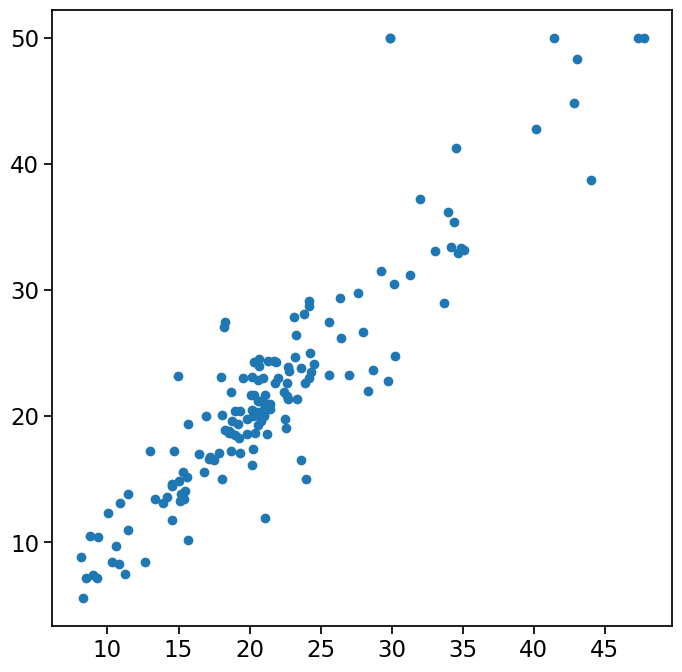

In [32]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

與 Bagged 回歸樹相關聯的測試集 MSE 是 14.63，約為使用最佳修剪單一樹所得結果的一半。我們可以使用 `n_estimators` 參數來改變從預設的 100 所增長的樹數量：

In [33]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

np.float64(14.605662565263161)

沒有太大變化。Bagging 和隨機森林不會因為增加樹的數量而過度擬合，但如果數量太少可能會欠擬合。

成長隨機森林的過程完全相同，除了我們使用較小的 `max_features` 參數值。預設情況下，`RandomForestRegressor()` 在建構回歸樹的隨機森林時使用 $p$ 個變數（即它預設為 Bagging），而 `RandomForestClassifier()` 在建構分類樹的隨機森林時使用 $\sqrt{p}$ 個變數。這裡我們使用 `max_features=6`。

In [34]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

np.float64(20.04276446710527)

測試集 MSE 是 20.04；這表明在這種情況下隨機森林比 Bagging 表現稍差。從擬合模型中提取 `feature_importances_` 值，我們可以查看每個變數的重要性。

In [35]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


這是由該變數的切分所導致的節點不純度總減少量的相對度量，在所有樹上平均（這在圖 8.9 中針對擬合 `Heart` 資料的模型進行了繪製）。

結果表明，在隨機森林中考慮的所有樹中，社區的財富水準（`lstat`）和房屋大小（`rm`）是迄今為止最重要的兩個變數。

## Boosting

在這裡我們使用 `scikit-learn.ensemble` 的 `GradientBoostingRegressor()` 來對 `Boston` 資料集擬合 boosted 回歸樹。對於分類我們會使用 `GradientBoostingClassifier()`。

參數 `n_estimators=5000` 表示我們想要 5000 棵樹，選項 `max_depth=3` 限制每棵樹的深度。參數 `learning_rate` 是前面在描述 boosting 時提到的 $\lambda$。

In [36]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

我們可以透過 `train_score_` 屬性看到訓練誤差如何遞減。要了解測試誤差如何遞減，我們可以使用 `staged_predict()` 方法來獲得路徑上的預測值。

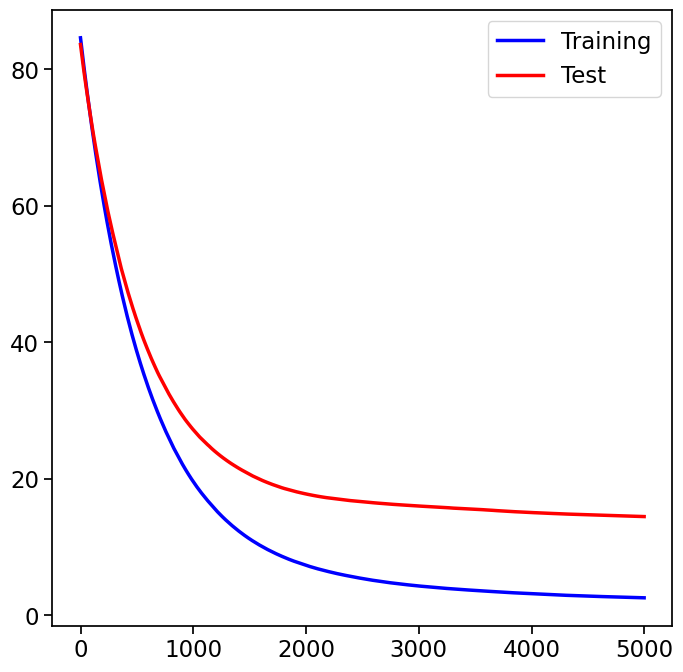

In [37]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

我們現在使用 boosted 模型在測試集上預測 `medv`：

In [38]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

np.float64(14.481405918831591)

獲得的測試 MSE 是 14.48，與 Bagging 的測試 MSE 相似。如果我們願意，我們可以對 (8.10) 中的收縮參數 $\lambda$ 執行不同值的 boosting。預設值是 0.001，但這很容易修改。這裡我們取 $\lambda=0.2$。

In [39]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

np.float64(14.501514553719565)

在這種情況下，使用 $\lambda=0.2$ 導致幾乎與使用 $\lambda=0.001$ 相同的測試 MSE。

## Bayesian 加法回歸樹

在本節中我們展示在 [`ISLP.bart`](https://islp.readthedocs.io/en/latest/api/generated/ISLP.bart.bart.html#ISLP.bart.bart.BART) 套件中找到的 BART Python 實作。我們對 `Boston` 住房資料集擬合一個模型。這個 `BART()` 估計器是為量化結果變數設計的，儘管其他實作可用於對分類結果擬合 logistic 和 probit 模型。

In [40]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

在這個資料集上，透過這種切分為測試和訓練，我們看到 BART 的測試誤差與隨機森林相似。

In [41]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

np.float64(22.145009458109225)

我們可以檢查每個變數在樹集合中出現多少次。這提供了類似於 boosting 和隨機森林的變數重要性圖的摘要。

In [42]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion

,0
crim,26.933333
zn,27.866667
indus,26.466667
chas,22.466667
nox,26.600000
rm,29.800000
age,22.733333
dis,26.466667
rad,23.666667
tax,24.133333


## XGBoost


### 分類任務

以下是在 scikit-learn 中使用交叉驗證建構 XGBoost 分類模型的基本步驟。

In [43]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

以下範本用於建構 XGBoost 分類器

In [45]:
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob',
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

1. `booster='gbtree'`
   `booster` 指的是基礎學習器（base learner），即在每一輪提升（boosting）過程中所建構的機器學習模型。`gbtree` 是 XGBoost 的預設值，代表「梯度提升樹」（Gradient Boosted Tree）。雖然較少見，但也可以使用其他類型的基礎學習器。

2. `objective='multi:softprob'`
   `objective` 參數決定了學習任務的目標函數，完整選項可參見 [XGBoost 官方文件](https://xgboost.readthedocs.io/en/latest/parameter.html) 中的「Learning Task Parameters」章節。
   `multi:softprob` 是處理多類別分類問題時的標準選項，常作為 `binary:logistic` 的替代方案，當資料集中包含多個類別時使用。該設定會計算每個類別的預測機率，並選擇機率最高者作為預測結果。若未明確指定，XGBoost 通常會自動推斷適合的目標函數。

3. `max_depth=6`
   `max_depth` 表示樹的最大深度，決定每棵樹的分支數量。這是影響預測是否平衡（避免過度擬合與欠擬合）的關鍵超參數之一。XGBoost 的預設值為 6，與隨機森林（random forest）不同，後者若未明確指定則不設限制。

4. `learning_rate=0.1`
   在 XGBoost 中，`learning_rate` 又稱為 `eta`。此超參數控制每棵樹對整體模型的貢獻比例，用來降低模型變異（variance）並提升穩定性。數值越小，學習步伐越慢，但整體表現更穩健。

5. `n_estimators=100`
   `n_estimators` 表示模型中總共使用多少棵提升樹，為集成學習（ensemble learning）中常見的參數。常見的策略是：降低 `learning_rate` 的同時提高 `n_estimators`，以提升模型的泛化能力與預測表現。

In [46]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [47]:
xgb.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### 回歸任務

以下是在 scikit-learn 中使用交叉驗證建構 XGBoost 回歸模型的基本步驟。

In [48]:
X,y = datasets.load_diabetes(return_X_y=True)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [59.397 60.322 69.036 63.211 66.953]
RMSE mean: 63.784


In [49]:
xgb.fit(X,y)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

如果沒有比較基準，我們不知道該分數的意義。使用 `.describe()` 方法將目標欄位 `y` 轉換為 pandas DataFrame 將提供預測變數欄位的四分位數和一般統計，如下所示：

In [50]:
pd.DataFrame(y).describe()

,0
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


分數 63.784 小於 1 個標準差，是令人滿意的結果。

### 速度比較

讓我們現在使用[系外行星資料集](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data)比較 `GradientBoostingClassifier` 和 `XGBoostClassifier` 的速度

In [51]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv


--2025-11-10 11:56:19--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv [following]
--2025-11-10 11:56:19--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [text/plain]
Saving to: ‘exopla

In [52]:
df = pd.read_csv('exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [53]:
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [54]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9874213836477987
Run Time: 624.8339729309082 seconds


In [55]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
xg_reg = XGBClassifier(n_estimators=100, max_depth=2, random_state=42)

# class column has to start from 0 (as required since version 1.3.2).
le = LabelEncoder() # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Fit xg_reg to training set
xg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 24.28720998764038 seconds


當涉及大資料時，快的演算法可以節省數週或數月的計算時間和資源！這種優勢在大資料世界中是巨大的。在 boosting 的世界中，XGBoost 是模型的首選，因為它具有極佳的速度和好的準確率。

### 超參數

XGBoost 有許多超參數。XGBoost 基礎學習器超參數將所有決策樹超參數作為起點。還有梯度提升超參數，因為 XGBoost 是梯度提升的增強版本。

In [56]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv

--2025-11-10 12:07:24--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv [following]
--2025-11-10 12:07:24--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/plain]
Saving to: ‘he

In [57]:
df = pd.read_csv('heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [58]:
# Split data into X and y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

在調整超參數之前，讓我們建構分類器，以便我們可以獲得基準分數作為起點。

在微調超參數時，GridSearchCV 和 RandomizedSearchCV 是標準選項。然而，`cross_val_score` 和 `GridSearchCV/RandomizedSearchCV` 並不以相同方式切分資料。一個解決方案是在使用交叉驗證時總是使用 `StratifiedKFold`。

分層摺疊在每個摺疊中包含相同百分比的目標值。如果資料集在目標欄位中包含 60% 的 1 和 40% 的 0，則每個分層測試集包含 60% 的 1 和 40% 的 0。當摺疊是隨機的時，可能一個測試集包含 70-30 切分，而另一個包含 50-50 切分的目標值。

In [59]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [60]:
# The 'binary:logistic' objective is standard for binary 分類 in determining the loss function
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.82 0.75 0.74 0.82 0.8 ]
Accuracy mean: 0.79


這裡的重點是在使用 `GridSearchCV` 和 `RandomizedSearchCV` 微調超參數時使用相同的摺疊來獲得新分數，使分數比較是公平的。

In [61]:
def grid_search(params, random=False):

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=42)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)

    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)

    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

這裡呈現的 XGBoost 超參數並不是全部。如要獲得完整的超參數列表，請閱讀官方文件 XGBoost 參數，網址：https://xgboost.readthedocs.io/en/latest/parameter.html。

#### learning_rate


`learning_rate` 收縮每輪 boosting 中樹的權重。透過降低 `learning_rate`，需要更多樹來產生更好的分數。降低 `learning_rate` 防止過度擬合，因為傳遞的權重大小較小。

使用預設值 0.3。以下是放置在我們的 grid_search 函數中的 `learning_rate` 起始範圍：

In [62]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params: {'learning_rate': 0.5}
Best score: 0.79557


當 `n_estimators` 增加時，降低 `learning_rate` 可能是有利的。

#### max_depth


`max_depth` 決定樹的長度，相當於切分輪數。限制 `max_depth` 防止過度擬合，因為個別樹只能增長到 `max_depth` 允許的範圍。XGBoost 提供預設的 `max_depth` 值為 6：

In [63]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Best params: {'max_depth': 3}
Best score: 0.81197


將 `max_depth` 從 6 改為 2 得到了更好的分數。`max_depth` 的較低值意味著變異數已減少。

#### gamma


稱為拉格朗日乘數的 `gamma` 提供了節點在根據損失函數進行進一步切分之前必須超越的閾值。`gamma` 值沒有上限。預設值是 0，超過 10 的任何值都被認為是非常高的。增加 `gamma` 會產生更保守的模型：

In [64]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

Best params: {'gamma': 0.1}
Best score: 0.81197


將 gamma 從 0 調整為 1 帶來了些微的效能提升。


#### min_child_weight


`min_child_weight` 指的是一個節點要進行分裂所需的最小權重總和。若該節點的樣本權重總和低於 `min_child_weight` 的設定值，則該節點將不再分裂。提高 `min_child_weight` 的數值可以降低過度擬合的風險。


In [65]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

Best params: {'min_child_weight': 4}
Best score: 0.81197


#### subsample


`subsample` 超參數限制每輪提升中使用的訓練資料（資料列）比例。將 `subsample` 從 100% 調低有助於減少過度擬合的情況。

In [66]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'subsample': 0.5}
Best score: 0.81536


分數再次略微提升，顯示仍存在輕微的過度擬合現象。

#### colsample_bytree


與 `subsample` 類似，`colsample_bytree` 會依據指定的比例隨機選取部分特徵欄位。此參數有助於限制特徵欄位的影響力，進而降低模型的變異性。

**注意：**`colsample_bytree` 的輸入值是比例（百分比），而不是特徵欄位的數量。


In [67]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'colsample_bytree': 0.7}
Best score: 0.80552


建議大家自行嘗試使用 `colsample_bylevel` 與 `colsample_bynode`。
`colsample_bylevel` 會在每一層樹的深度中隨機選取特徵欄位，
而 `colsample_bynode` 則是在評估每個節點分裂時隨機選取特徵欄位。


#### n_estimators


請記住，`n_estimators` 表示集成模型中樹的數量。對於 XGBoost 而言，`n_estimators` 是指用於擬合殘差的樹的總數。
可以從預設值 100 開始進行網格搜尋，並依序將樹的數量加倍至 800，設定方式如下：


In [68]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Best params: {'n_estimators': 400}
Best score: 0.79541


由於我們的資料集較小，增加 `n_estimators` 並未帶來更好的結果。

#### 使用 early stopping


`early_stopping_rounds` 並非一個超參數，而是一種用來最佳化 `n_estimators` 的策略。

在一般的超參數選擇中，模型會在所有提升（boosting）輪次完成後，才計算測試分數。然而，若要使用提前停止（early stopping），則必須在每一輪訓練後都能取得一個測試分數。為此，可以透過 `.fit` 方法中的 `eval_metric` 和 `eval_set` 參數來實現：

* `eval_metric`：指定評估指標，分類常用 `'error'`，迴歸常用 `'rmse'`。
* `eval_set`：指定用來評估的測試資料集，通常設為 `X_test` 與 `y_test`。


以下步驟會在使用預設的 `n_estimators=100` 訓練過程中，顯示每一輪的評估指標：


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42, eval_metric='error')
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set)
# make 預測s for test data
y_pred = model.predict(X_test)
# evaluate 預測s
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.15789
[1]	validation_0-error:0.19737
[2]	validation_0-error:0.17105
[3]	validation_0-error:0.19737
[4]	validation_0-error:0.15789
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.18421
[7]	validation_0-error:0.18421
[8]	validation_0-error:0.18421
[9]	validation_0-error:0.18421
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.18421
[13]	validation_0-error:0.18421
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.17105
[16]	validation_0-error:0.17105
[17]	validation_0-error:0.17105
[18]	validation_0-error:0.19737
[19]	validation_0-error:0.18421
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.19737
[23]	validation_0-error:0.19737
[24]	validation_0-error:0.19737
[25]	validation_0-error:0.17105
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.17105
[30]	validation_0-error:0.18421
[31]	validation_0-

我們知道當 `n_estimators=100` 時，使用 `StratifiedKFold` 交叉驗證的平均準確率為 78%。分數的差異來自於不同測試集之間的差異性。

#### early_stopping_rounds


`early_stopping_rounds` 是在模型訓練時可與 `eval_metric` 和 `eval_set` 一併使用的可選參數。
讓我們嘗試設定 `early_stopping_rounds=10`。
以下是加入 `early_stopping_rounds=10` 後的原始程式碼：


In [79]:
eval_metric = 'error'
model = XGBClassifier(random_state=42, early_stopping_rounds=10, eval_metric=eval_metric)

eval_set = [(X_test, y_test)]

# eval_metric 和 eval_set 保留在 fit() 中，因為它們是訓練時需要的資料
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.15789
[1]	validation_0-error:0.19737
[2]	validation_0-error:0.17105
[3]	validation_0-error:0.19737
[4]	validation_0-error:0.15789
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.18421
[7]	validation_0-error:0.18421
[8]	validation_0-error:0.18421
[9]	validation_0-error:0.18421
Accuracy: 84.21%


較為完整的作法是使用較大的數值，例如設定 `n_estimators = 5000` 和 `early_stopping_rounds=100`。透過設置 `early_stopping_rounds=100`，可以保證至少訓練到 XGBoost 預設的 100 棵提升樹。
以下是最多訓練 5,000 棵樹、且在連續 100 輪未見效能提升時即停止的程式碼：


In [80]:
model = XGBClassifier(random_state=42, n_estimators=5000, eval_metric=eval_metric, early_stopping_rounds=100)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_set=eval_set)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.15789
[1]	validation_0-error:0.19737
[2]	validation_0-error:0.17105
[3]	validation_0-error:0.19737
[4]	validation_0-error:0.15789
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.18421
[7]	validation_0-error:0.18421
[8]	validation_0-error:0.18421
[9]	validation_0-error:0.18421
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.18421
[13]	validation_0-error:0.18421
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.17105
[16]	validation_0-error:0.17105
[17]	validation_0-error:0.17105
[18]	validation_0-error:0.19737
[19]	validation_0-error:0.18421
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.19737
[23]	validation_0-error:0.19737
[24]	validation_0-error:0.19737
[25]	validation_0-error:0.17105
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.17105
[30]	validation_0-error:0.18421
[31]	validation_0-

#### Automatically hyperparamter tuning


鼓勵嘗試 https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py 進行超參數調整。

### 對於類別變數與缺失值

XGBoost 對類別變數有實驗性支援，我們可以在這裡查看：https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html。但它只適用於少數樹方法，仍然建議編碼我們的資料：https://www.kaggle.com/code/shahules/-overview--encoding-techniques/notebook。另一方面，缺失值可以由 XGBoost 處理，如 https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values 所述。

In [81]:
!gdown 1WkuxuToarMFAHYIQ85SW20YSXrfJsMEH

Downloading...
From: https://drive.google.com/uc?id=1WkuxuToarMFAHYIQ85SW20YSXrfJsMEH
To: /content/melb_data.csv
100% 2.09M/2.09M [00:00<00:00, 26.8MB/s]


In [82]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical 特徵s
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [83]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [84]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                    random_state=42, n_jobs=-1) # You can either specify missing=-9999 or leave it as it is
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [85]:
preds = xgb.predict(X_valid)

## Lightgbm


### 分類任務

In [86]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [87]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 4
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -1.054937
[LightGBM] [Info] Start training from score -1.080913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

LGBMClassifier(n_jobs=-1, random_state=42)

In [88]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 112, number of used features: 4
[LightGBM] [Info] Start training from score -1.163151
[LightGBM] [Info] Start training from score -1.054937
[LightGBM] [Info] Start training from score -1.080913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [89]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### 回歸任務

In [90]:
X,y = datasets.load_diabetes(return_X_y=True)

lgbr = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(lgbr, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 353, number of used features: 10
[LightGBM] [Info] Start training from score 156.543909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names


In [91]:
lgbr.fit(X,y)
lgbr.get_params()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 442, number of used features: 10
[LightGBM] [Info] Start training from score 152.133484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### 速度

In [92]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [93]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
lg_reg = lgb.LGBMClassifier(n_estimators=100, max_depth=2, random_state=42)

# Fit xg_reg to training set
lg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = lg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

[LightGBM] [Info] Number of positive: 26, number of negative: 3789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.501595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815235
[LightGBM] [Info] Number of data points in the train set: 3815, number of used features: 3197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006815 -> initscore=-4.981761
[LightGBM] [Info] Start training from score -4.981761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### 超參數

以下設定實務可用來改善我們的模型效率。

* **num_leaves** ：這是控制樹模型複雜度的主要參數。理想情況下，`num_leaves` 的值應小於或等於 2^(max_depth)。超過此值會導致過度擬合。

* **min_data_in_leaf** ：將其設為大值可以避免樹長得太深，但可能導致欠擬合。在實務上，對於大資料集設為數百或數千就足夠了。

* **max_depth** ：我們也可以使用 `max_depth` 來明確限制樹的深度。

1. **為了更快的速度**

* 透過設定 `bagging_fraction` 和 `bagging_freq` 使用 Bagging。
* 透過設定 `feature_fraction` 使用特徵子抽樣。
* 使用較小的 `max_bin`。
* 使用 `save_binary` 來加速未來學習中的資料載入。

2. **為了更好的準確率**

* 使用大的 `max_bin`（可能較慢）。
* 使用小的 `learning_rate` 配合大的 `num_iterations`
* 使用大的 `num_leaves`（可能導致過度擬合）
* 嘗試直接使用類別特徵。

3. **處理過度擬合**

* 使用 `min_data_in_leaf` 和 `min_sum_hessian_in_leaf`
* 嘗試 `lambda_l1`、`lambda_l2` 和 `min_gain_to_split` 進行正規化
* 嘗試 `max_depth` 來避免樹長得太深
* 嘗試 `dart`

查看 https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 進行超參數調整。

### 對於類別變數與缺失值

LightGBM 預設啟用缺失值處理。請參見 https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle。它也處理類別變數，如這裡所述：https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support

In [94]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical 特徵s
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [95]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [96]:
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42, n_jobs=-1)
lgbr.fit(X, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 10864, number of used features: 18
[LightGBM] [Info] Start training from score 1076087.345453


LGBMRegressor(n_jobs=-1, random_state=42)

In [97]:
preds = lgbr.predict(X_v)

## CatBoost


在本節中，我們將探索使用 CatBoost 的一些基本情況，如模型訓練、交叉驗證和預測

### 分類任務

In [98]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [99]:
clf = CatBoostClassifier(boosting_type='Plain', learning_rate=0.1, n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent')
clf.fit(X_train, y_train)

In [100]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [101]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'class_names': [0, 1, 2],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'lo

### 回歸

In [102]:
X,y = datasets.load_diabetes(return_X_y=True)

catb = CatBoostRegressor(boosting_type='Plain', learning_rate=0.1, random_state=42, n_estimators=100, thread_count=-1, logging_level = 'Silent')

scores = cross_val_score(catb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [54.744 56.113 59.635 56.908 56.579]
RMSE mean: 56.796


In [103]:
catb.fit(X,y)
catb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lear

### 速度

In [104]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [105]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
ca_reg = CatBoostClassifier(n_estimators=100, max_depth=2, random_state=42, logging_level = 'Silent')

# Fit xg_reg to training set
ca_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = ca_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 15.102735042572021 seconds


### 超參數

我們可以在 https://catboost.ai/en/docs/references/training-parameters/ 查看更多詳細資訊。還有關於超參數調整的教學：https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb

### 對於類別變數與缺失值

CatBoost 與其他梯度提升函式庫的差異之一是它先進的類別特徵處理（實際上套件名稱中的 "Cat" 代表 "CATegorical"）。

CatBoost 能很好地開箱即用處理類別資料。然而，它也有大量的訓練參數，提供對類別特徵預處理的精細控制。

CatBoost 中用於處理類別特徵的相關參數眾多且繁複。以下是完整參數清單：

* **`one_hot_max_size`（整數）**
  對所有類別數量小於等於此數值的類別特徵使用 one-hot 編碼，這些特徵不會經過更複雜的編碼處理。

* **`model_size_reg`（浮點數，範圍 0 到無限大）**
  模型大小正規化係數。數值越大，模型越小。僅對含有類別特徵的模型需要此正規化（其他模型本身就很小）。若類別特徵的取值很多，模型可能會大到數十 GB。當此參數不為 0 時，使用高基數類別特徵（或其組合）會被加上懲罰，因此結果模型中會選擇較少這類特徵。預設為 `0.5`。

* **`max_ctr_complexity`**
  可進行組合的最大特徵數量。每一個組合可能包含一個或多個類別特徵，也可包含類似「數值特徵 > 閾值」形式的二元特徵。CPU 上做迴歸任務的預設值為 `4`。

* **`has_time`（布林值）**
  若設為 `True`，將跳過類別特徵處理的第一步（排列 permutation），這適用於資料按時間順序排列的情境。對我們的資料集來說不需要此設定。預設為 `False`。

* **`simple_ctr`**
  用於簡單類別特徵的量化（quantization）設定。

* **`combinations_ctr`**
  用於組合類別特徵的量化設定。

* **`per_feature_ctr`**
  每個類別特徵的個別量化設定。

* **`counter_calc_method`**
  用於設定是否在計算頻率 Counter 時使用驗證資料集（透過 `fit` 方法中的 `eval_set` 傳入）。預設值為 `Full`，即會使用驗證集中的資料。若不希望使用驗證集，可設定為 `SkipTest`。

* **`ctr_target_border_count`**
  針對需要目標值量化的類別特徵，所使用的最大分段數。對於迴歸任務的預設值為 `1`。

* **`ctr_leaf_count_limit`**
  含有類別特徵的樹葉節點最大數量。預設為 `None`，即不設限。

* **`store_all_simple_ctr`**
  若有設定 `ctr_leaf_count_limit`，當模型無法再對類別特徵進行分裂時，這個參數會決定是否限制所有類別特徵或僅限制特徵組合。預設為 `False`，即限制適用於原始類別特徵與自動組合特徵；若設為 `True`，僅限制自動產生的特徵組合。

⚠️ 其中，`simple_ctr`、`combinations_ctr` 和 `per_feature_ctr` 為較複雜的設定，用來控制類別特徵處理流程中的第二與第三步驟。

In [106]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical 特徵s
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [107]:
categorical_features_names = list(X_train_cat.columns)

for col in categorical_features_names:
  X[col] = X.loc[:,col].fillna(value='nan')
  X_v[col] = X_v.loc[:,col].fillna(value='nan')
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [108]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

In [109]:
preds = catbr.predict(X_v)

我們首先嘗試讓 CatBoost 對所有類別特徵使用 one-hot 編碼。根據官方文件說明，對於已使用 one-hot 編碼的特徵，CatBoost 不會再計算其他類型的編碼。

In [110]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, one_hot_max_size=500)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163165.1377008556

讓我們嘗試將模型大小正規化係數設為 0——這表示我們允許模型任意使用所有類別特徵及其組合數量，不加限制。

In [111]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

165007.46639148306

In [112]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=1)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

160827.54657606702

注意：任意多個類別特徵的組合都可能被視為一個新的特徵。
雖然官方文件中未明確說明，但此參數的值必須小於 15。

In [113]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=6)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163529.3517553931

In [114]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164721.46472522244

Counter 方法與傳統的頻率編碼（Frequency Encoding）非常相似。

In [115]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Counter', combinations_ctr='Counter')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164993.47954656056

現在我們來設定那些需要對目標值進行量化（target quantization）的編碼方法。
首先要選擇的是 `Borders`（邊界）或 Buckets（桶化）方式。


In [116]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Borders', combinations_ctr='Borders')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166920.94141120723

In [117]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Buckets', combinations_ctr='Buckets')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

168168.9386958123

在 CatBoost 中，對單一類別特徵使用多種編碼方式是相當常見的做法。實際上，CatBoost 預設會為每個類別特徵產生四種不同的編碼方式。

* 首先，它會使用 `Borders` 方法，並設定一個目標邊界（`TargetBorderCount=1`）（例如：我們想知道某個類別特徵是否會讓汽車價格更高）。
  接著產生的浮點數編碼會進一步被離散化為 `CtrBorderCount=15` 個不同的區間。
  此方法會使用三組 Prior 參數來建立三種不同的編碼方式：`Prior=0/1`、`Prior=0.5/1` 和 `Prior=1/1`。

* 此外，對每個類別特徵也會產生一種使用 Counter 方法的編碼。
  這裡同樣會使用 `CtrBorderCount=15` 個邊界，但只使用一組 Prior 值：`Prior=0/1`。


In [118]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, ctr_target_border_count=10)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166281.68070428775

In [119]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

## Voting 與 Stacking

In [120]:
Carseats = load_data('Carseats')

print(Carseats.shape)
# Check for missing values
assert Carseats.isnull().sum().sum() == 0

# Create binary variable High 1 if Sales > 8
Carseats['High'] = (Carseats['Sales'] > 8).astype(np.float64)

predictors = Carseats.drop(["Sales","High"], axis=1).columns
X = pd.get_dummies(Carseats[predictors], drop_first=True) #sklearn does not have built-in support for categorical variable
y = Carseats["High"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

(400, 11)


In [121]:

clf1 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=10))
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = GaussianNB()

estimators = [
    ("knn", clf1),
    ("dc", clf2),
    ("nb", clf3)
]

vclf = VotingClassifier(estimators=estimators, voting='hard')

k = 5
kf5 = KFold(n_splits=k, shuffle=True, random_state=1)

print('5-fold cross validation:\n')


for clf, label in zip([clf1, clf2, clf3, vclf],
                      ['KNN',
                       'DecisionTreeClassifier',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.82 (+/- 0.04) [StackingClassifier]


查看 https://scikit-learn.org/stable/modules/generated/scikit-learn.ensemble.VotingClassifier.html 了解更多詳情

In [122]:
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'DecisionTreeClassifier',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=kf5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.07) [DecisionTreeClassifier]
Accuracy: 0.79 (+/- 0.07) [Naive Bayes]
Accuracy: 0.81 (+/- 0.05) [StackingClassifier]


查看 https://scikit-learn.org/stable/modules/generated/scikit-learn.ensemble.StackingClassifier.html 或 http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#stackingcvclassifier 了解更多詳情